In [1]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model, load_model
from keras import backend as K
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [3]:
# Выводит изображение на экран
def print_image(image):
    plt.figure(figsize=(10,10))
    plt.axis('off')
    plt.imshow(image)
    plt.show()

In [4]:
# Производит изменение размера изображения в случайной пропорции
# Возвращает измененное изображение
def resize_image(image):
    # Получаем случаную пропорцию
    ratio = 1.4 + np.random.uniform(-0.6, 0.6)
    # Вычисляем новые размеры изображения
    dsize = (int(image.shape[0] * ratio), int(image.shape[1] * ratio))
    # Измененное по размеру изображение
    new_image = cv2.resize(image, dsize)
    return new_image

In [5]:
# Производит вращение изображения image на случайный угол
# Возвращает повернутое изображение
def rotate_image(image):
    # Случайный угол из нормального распределения
    angle = np.random.normal(0, 20)
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result

In [6]:
# Создает холст из изображений цифр
def generate_image(collection_images, collection_gt, resize=True, rotate=True):
    placed = np.zeros([256,256],dtype=np.float32)
    placed_gt = np.zeros([256,256, 10],dtype=np.float32)
    # Генерируются неповторяющиеся номера ячеек для каждого изображения из collection_images
    cells = random.sample(range(0, 15), len(collection_images))
    for image, gt, cell in zip(collection_images, collection_gt, cells):
        # Вычисляем номер строки, в которой будет размещено данное изображение
        number_row = cell // 4
        # Вычисляем номер столбца, в котором будет размещено данное изображение
        number_column = cell % 4
        # Вычисляем координаты, по которым будет размещено данное изображение
        # Исходя из того, что ширина и высота ячейки составляет 64 (сетка 4x4 для картинки 256x256)
        pos = np.array([64 * number_row, 64 * number_column])
        # Изменяем размер изображения
        if resize:
            image = resize_image(image)
        # Вращаем изображение
        if rotate:
            image = rotate_image(image)
        image_gt = image.copy()
        image_gt[image_gt < 20] = 0
        image_gt[image_gt >= 20] = 1
        # Вставка изображения
        placed[pos[0]:pos[0]+image.shape[0],pos[1]:pos[1]+image.shape[1]] = np.max([placed[pos[0]:pos[0]+image.shape[0],pos[1]:pos[1]+image.shape[1]],image],axis=0)
        placed_gt[pos[0]:pos[0]+image_gt.shape[0],pos[1]:pos[1]+image_gt.shape[1], gt] = np.max([placed_gt[pos[0]:pos[0]+image_gt.shape[0],pos[1]:pos[1]+image_gt.shape[1], gt],image_gt],axis=0)
    return placed, placed_gt

In [7]:
# Генерируем датасет размера size_dataset с картинками
def generate_dataset(batch_size):
    len_train = len(x_train) 
    while True:
        result_image = []
        result_image_gt = []
        for _ in range(batch_size):
            # Количество цифр, которые будут распологаться на данной картинке
            # Выбирается случайным образом из диапазона [4, 14]
            size_collection = random.randint(4, 14)
            # Номера картинок, которые попадут на текущее изображение
            index = np.random.choice(np.arange(0, len_train), size=size_collection, replace=True)
            # Будет ли использоваться resize для картинок
            resize = np.random.choice([True, False])
            # Будет ли использоваться rotate для картинок
            rotate = np.random.choice([True, False])
            # Цифры и gt, которые попадут на данную картинку
            collection_images = x_train[index]
            collection_gt = y_train[index]
            image, image_gt = generate_image(collection_images, collection_gt, resize, rotate)
            result_image.append(image)
            result_image_gt.append(image_gt)
        result_image = np.array(result_image)
        result_image_gt = np.array(result_image_gt)
        yield np.expand_dims(result_image, -1), result_image_gt

In [8]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)

def dice_coef_loss(y_true, y_pred):
    return 1.0-dice_coef(y_true, y_pred)

In [9]:
# Unet модель
def create_unet():
    inputs = layers.Input(shape=(256, 256, 1))
    conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = layers.concatenate([layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = layers.concatenate([layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = layers.concatenate([layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = layers.concatenate([layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    output = layers.Conv2D(10, (1, 1), activation='sigmoid')(conv9)
    
    model = Model(inputs, output)
    model.compile(optimizer='Adam', loss=dice_coef_loss, metrics=[dice_coef])

    return model

In [10]:
model = create_unet()

In [11]:
model.fit(generate_dataset(batch_size=20), steps_per_epoch=4, epochs=150)

Epoch 1/150
4/4 [==============================] - 52s 13s/step - loss: 0.9887 - dice_coef: 0.0113
Epoch 2/150
4/4 [==============================] - 53s 13s/step - loss: 0.9877 - dice_coef: 0.0123
Epoch 3/150
4/4 [==============================] - 51s 13s/step - loss: 0.9869 - dice_coef: 0.0131
Epoch 4/150
4/4 [==============================] - 55s 14s/step - loss: 0.9868 - dice_coef: 0.0132
Epoch 5/150
4/4 [==============================] - 62s 15s/step - loss: 0.9844 - dice_coef: 0.0156
Epoch 6/150
4/4 [==============================] - 52s 13s/step - loss: 0.9736 - dice_coef: 0.0264
Epoch 7/150
4/4 [==============================] - 56s 14s/step - loss: 0.9699 - dice_coef: 0.0301
Epoch 8/150
4/4 [==============================] - 52s 13s/step - loss: 0.9563 - dice_coef: 0.0437
Epoch 9/150
4/4 [==============================] - 51s 13s/step - loss: 0.9570 - dice_coef: 0.0430
Epoch 10/150
4/4 [==============================] - 53s 14s/step - loss: 0.9593 - dice_coef: 0.0407
Epoch 11/

4/4 [==============================] - 56s 14s/step - loss: 0.5618 - dice_coef: 0.4382
Epoch 84/150
4/4 [==============================] - 57s 14s/step - loss: 0.5550 - dice_coef: 0.4450
Epoch 85/150
4/4 [==============================] - 56s 14s/step - loss: 0.5789 - dice_coef: 0.4211
Epoch 86/150
4/4 [==============================] - 57s 14s/step - loss: 0.5754 - dice_coef: 0.4246
Epoch 87/150
4/4 [==============================] - 54s 13s/step - loss: 0.5237 - dice_coef: 0.4763
Epoch 88/150
4/4 [==============================] - 57s 14s/step - loss: 0.5121 - dice_coef: 0.4879
Epoch 89/150
4/4 [==============================] - 56s 14s/step - loss: 0.5120 - dice_coef: 0.4880
Epoch 90/150
4/4 [==============================] - 58s 14s/step - loss: 0.5271 - dice_coef: 0.4729
Epoch 91/150
4/4 [==============================] - 55s 14s/step - loss: 0.5003 - dice_coef: 0.4997
Epoch 92/150
4/4 [==============================] - 56s 14s/step - loss: 0.5171 - dice_coef: 0.4829
Epoch 93/150


In [12]:
model.save('unet_model')

INFO:tensorflow:Assets written to: unet_model\assets


In [45]:
test_image, test_gt_image = next(generate_dataset(1))
predict_gt = model.predict(test_image)

In [46]:
model.evaluate(test_image, test_gt_image)

1/1 [==============================] - 0s 170ms/step - loss: 0.0663 - dice_coef: 0.9337


[0.0662999153137207, 0.9337000846862793]

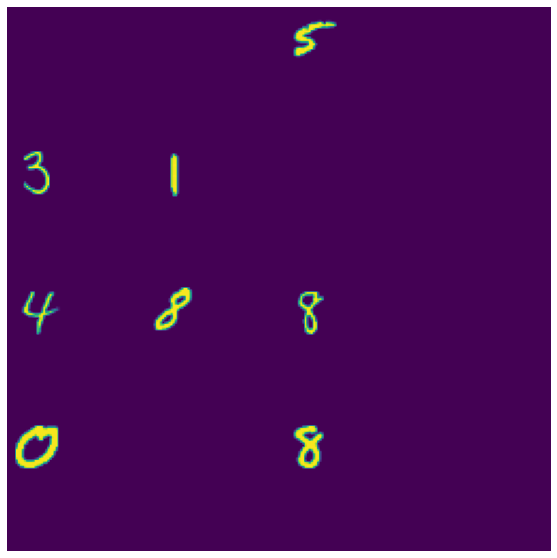

In [47]:
print_image(test_image[0, :, :])

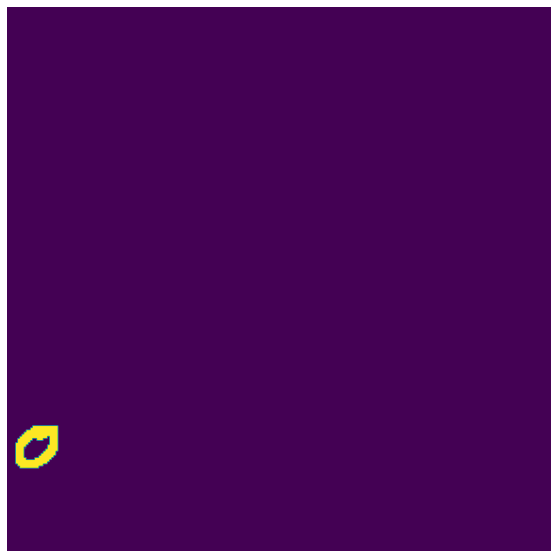

In [48]:
print_image(predict_gt[0, :, :, 0])

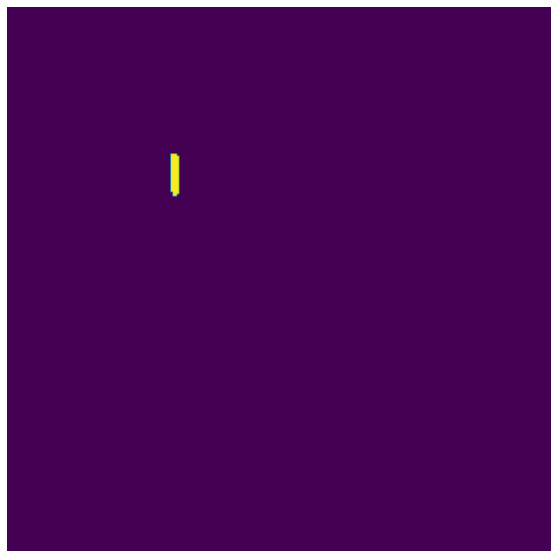

In [49]:
print_image(predict_gt[0, :, :, 1])

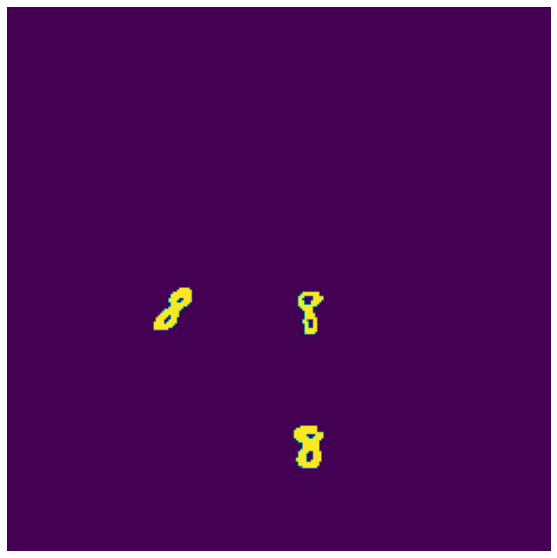

In [51]:
print_image(predict_gt[0, :, :, 8])